In [1]:
import codecs
import copy
import csv
import gc
import os
import pickle
import random
import time
import codecs
from typing import Dict, List, Tuple, Union
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from nltk import wordpunct_tokenize
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.framework import ops, tensor_util
from tensorflow.python.keras.utils import losses_utils, tf_utils
from tensorflow.python.ops import math_ops
from tensorflow.python.ops.losses import util as tf_losses_util
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, XLMRobertaTokenizer
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
class LossFunctionWrapper(tf.keras.losses.Loss):
    def __init__(self, fn, reduction=losses_utils.ReductionV2.AUTO, name=None, **kwargs):
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        if isinstance(y_pred, tf.Tensor) and isinstance(y_true, tf.Tensor): y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(y_pred, y_true)
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = tf.keras.backend.eval(v) \
                if tf_utils.is_tensor_or_variable(v) \
                else v
        base_config = super(LossFunctionWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
def distance_based_log_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    margin = 1.0
    p = (1.0 + tf.math.exp(-margin)) / (1.0 + tf.math.exp(y_pred - margin))
    return tf.keras.backend.binary_crossentropy(target=y_true, output=p)

In [5]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str, figure_id: int=1):
    val_metric_name = 'val_' + metric_name
    plt.figure(figure_id, figsize=(5, 5))
    plt.plot(list(range(len(history.history[metric_name]))),
             history.history[metric_name], label='Training {0}'.format(metric_name))
    if val_metric_name in history.history:
        plt.plot(list(range(len(history.history['val_' + metric_name]))),
                 history.history['val_' + metric_name], label='Validation {0}'.format(metric_name))
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [6]:
class DBLLogLoss(LossFunctionWrapper):
    def __init__(self, reduction=losses_utils.ReductionV2.AUTO, name='distance_based_log_loss'):
        super(DBLLogLoss, self).__init__(distance_based_log_loss, name=name, reduction=reduction)

In [7]:
class AttentionMaskLayer(tf.keras.layers.Layer):
    def __init__(self, pad_token_id: int, **kwargs):
        self.pad_token_id = pad_token_id
        super(AttentionMaskLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AttentionMaskLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return tf.keras.backend.cast(x=tf.math.not_equal(x=inputs,y=self.pad_token_id),dtype='int32')

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        return {"pad_token_id": self.pad_token_id}

In [8]:
def tokenize_all(texts, tokenizer, maxlen):
    tokenized_texts = []
    for text in texts:
        tokens = tokenizer.encode(text, max_length=maxlen, pad_to_max_length=True)
        tokenized_texts.append(tokens)
    return tokenized_texts


In [9]:
def load_train_set(file_name: str, text_field: str, sentiment_fields: List[str], lang_field: str) -> Dict[str, List[Tuple[str, int]]]:
    header = []
    line_idx = 1
    data_by_lang = dict()
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        data_reader = csv.reader(fp, quotechar='"', delimiter=',')
        for row in data_reader:
            if len(row) > 0:
                if len(header) == 0:
                    header = copy.copy(row)
                    text_field_index = header.index(text_field)
                    try:
                        lang_field_index = header.index(lang_field)
                    except:
                        lang_field_index = -1
                    indices_of_sentiment_fields = []
                    for cur_field in sentiment_fields:
                        indices_of_sentiment_fields.append(header.index(cur_field))
                else:
                    if len(row) == len(header):
                        text = row[text_field_index].strip()
                        if lang_field_index >= 0:
                            cur_lang = row[lang_field_index].strip()
                        else:
                            cur_lang = 'en'
                        max_proba = 0.0
                        for cur_field_idx in indices_of_sentiment_fields:
                            try:
                                cur_proba = float(row[cur_field_idx])
                            except:
                                cur_proba = -1.0
                            if cur_proba > max_proba:
                                max_proba = cur_proba
                        new_label = 1 if max_proba >= 0.5 else 0
                        if cur_lang not in data_by_lang:
                            data_by_lang[cur_lang] = []
                        data_by_lang[cur_lang].append((text, new_label))
    return data_by_lang

In [10]:
def load_test_set(file_name: str, id_field: str, text_field: str, lang_field: str) -> Dict[str, List[Tuple[str, int]]]:
    data_by_lang = dict()
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        data_reader = csv.reader(fp, quotechar='"', delimiter=',')
        header = next(data_reader)
        id_field_index = header.index(id_field)
        text_field_index = header.index(text_field)
        lang_field_index = header.index(lang_field) if lang_field in header else -1
        
        for row in data_reader:
            if len(row) == len(header):
                try:
                    id_value = int(row[id_field_index])
                except ValueError:
                    id_value = -1
                text = row[text_field_index].strip()
                cur_lang = row[lang_field_index].strip() if lang_field_index >= 0 else 'en'
                
                if cur_lang not in data_by_lang:
                    data_by_lang[cur_lang] = []
                
                data_by_lang[cur_lang].append((text, id_value))
    
    return data_by_lang


In [11]:
def generate_text_probabilities(source_texts: List[Tuple[str, int]], interesting_indices: List[int]) -> np.ndarray:
    lengths_of_texts = []
    max_chars_number = 0
    for idx in interesting_indices:
        cur_chars_number = len(source_texts[idx][0])
        lengths_of_texts.append(cur_chars_number)
        if cur_chars_number > max_chars_number:
            max_chars_number = cur_chars_number
    probabilities = np.zeros((len(lengths_of_texts),), dtype=np.float64)
    counter = 0
    for idx, val in enumerate(lengths_of_texts):
        if val > 10:
            probabilities[idx] = max_chars_number * 10 - val
        else:
            counter += 1
    probabilities /= np.sum(probabilities)
    min_proba = 0.5 / float(probabilities.shape[0])
    for idx in range(probabilities.shape[0]):
        if probabilities[idx] > 0.0:
            if probabilities[idx] < min_proba:
                probabilities[idx] = min_proba
    return probabilities / np.sum(probabilities)

In [12]:
def build_siamese_dataset(texts: Dict[str, List[Tuple[str, int]]], dataset_size: int, tokenizer: XLMRobertaTokenizer, maxlen: int, batch_size: int, shuffle: bool) -> Tuple[tf.data.Dataset, int]:
    language_pairs = set()
    for language in texts.keys():
        for other_language in texts:
            if other_language == language:
                language_pairs.add((language, other_language))
            else:
                pair_1 = (language, other_language)
                pair_2 = (other_language, language)
                if (pair_1 not in language_pairs) and (pair_2 not in language_pairs):
                    language_pairs.add(pair_1)
    language_pairs = sorted(list(language_pairs))
    n_samples_for_lang_pair = int(np.ceil(dataset_size / float(len(language_pairs))))
    text_pairs_and_labels = []
    for left_lang, right_lang in language_pairs:
        left_positive_indices = [idx for idx in range(len(texts[left_lang])) if texts[left_lang][idx][1] > 0 and len(texts[left_lang][idx][0]) > 10]

        left_positive_probas = generate_text_probabilities(source_texts=texts[left_lang], interesting_indices=left_positive_indices)

        left_negative_indices = [idx for idx in range(len(texts[left_lang])) if texts[left_lang][idx][1] == 0 and len(texts[left_lang][idx][0]) > 10]

        left_negative_probas = generate_text_probabilities( source_texts=texts[left_lang], interesting_indices=left_negative_indices)
        
        right_positive_indices = [idx for idx in range(len(texts[right_lang])) if texts[right_lang][idx][1] > 0 and len(texts[right_lang][idx][0]) > 10]


        right_positive_probas = generate_text_probabilities(source_texts=texts[right_lang], interesting_indices=right_positive_indices)
        
        right_negative_indices = [idx for idx in range(len(texts[right_lang])) if texts[right_lang][idx][1] == 0 and len(texts[right_lang][idx][0]) > 10]

        right_negative_probas = generate_text_probabilities(source_texts=texts[right_lang], interesting_indices=right_negative_indices)
        
        used_pairs = set()
        number_of_samples = 0
        iterations = n_samples_for_lang_pair // 4
        if len(left_positive_indices) > iterations:
            left_indices = np.random.choice(left_positive_indices,min(iterations * 2, len(left_positive_indices)), p=left_positive_probas, replace=False).tolist()
        else:
            left_indices = left_positive_indices
        if len(right_positive_indices) > iterations:
            right_indices = np.random.choice(right_positive_indices, min(iterations * 2, len(right_positive_indices)), p=right_positive_probas, replace=False).tolist()
        else:
            right_indices = right_positive_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]
        
        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            text_pairs_and_labels.append((texts[left_lang][left_idx][0],texts[right_lang][right_idx][0],1))
            number_of_samples += 1
            if number_of_samples >= iterations:
                break
        number_of_samples = 0
        iterations = (2 * n_samples_for_lang_pair) // 4
        iterations -= n_samples_for_lang_pair // 4
        if len(left_negative_indices) > iterations:
            left_indices = np.random.choice(left_negative_indices,min(iterations * 2, len(left_negative_indices)),p=left_negative_probas, replace=False).tolist()
        else:
            left_indices = left_negative_indices
        if len(right_negative_indices) > iterations:
            right_indices = np.random.choice(right_negative_indices,min(iterations * 2, len(right_negative_indices)),p=right_negative_probas, replace=False).tolist()
        else:
            right_indices = right_negative_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]
        
        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            text_pairs_and_labels.append((texts[left_lang][left_idx][0],texts[right_lang][right_idx][0],1))
            number_of_samples += 1
            if number_of_samples >= iterations:
                break
        
        number_of_samples = 0
        iterations = n_samples_for_lang_pair
        iterations -= (2 * n_samples_for_lang_pair) // 4
        if len(left_negative_indices) > iterations:
            left_indices = np.random.choice(left_negative_indices,min(iterations * 2, len(left_negative_indices)),p=left_negative_probas, replace=False).tolist()
        else:
            left_indices = left_negative_indices
        if len(right_positive_indices) > iterations:
            right_indices = np.random.choice(right_positive_indices,min(iterations * 2, len(right_positive_indices)),p=right_positive_probas, replace=False).tolist()
        else:
            right_indices = right_positive_indices
        if len(left_indices) < len(right_indices):
            right_indices = right_indices[:len(left_indices)]
        elif len(left_indices) > len(right_indices):
            left_indices = left_indices[:len(right_indices)]

        random.shuffle(left_indices)
        random.shuffle(right_indices)
        for left_idx, right_idx in zip(left_indices, right_indices):
            if (right_idx == left_idx) and (left_lang == right_lang):
                continue
            if (left_idx, right_idx) in used_pairs:
                continue
            used_pairs.add((left_idx, right_idx))
            used_pairs.add((right_idx, left_idx))
            if random.random() >= 0.5:
                text_pairs_and_labels.append((texts[left_lang][left_idx][0],texts[right_lang][right_idx][0],0))
            else:
                text_pairs_and_labels.append((texts[right_lang][right_idx][0],texts[left_lang][left_idx][0],0))
            number_of_samples += 1
            if number_of_samples >= iterations:
                break

    random.shuffle(text_pairs_and_labels)
    n_steps = len(text_pairs_and_labels) // batch_size
    
    tokens_of_left_texts = tokenize_all(texts=[cur[0] for cur in text_pairs_and_labels],tokenizer=tokenizer, maxlen=maxlen)
    tokens_of_left_texts = np.array(tokens_of_left_texts, dtype=np.int32)

    tokens_of_right_texts = tokenize_all(texts=[cur[1] for cur in text_pairs_and_labels],tokenizer=tokenizer, maxlen=maxlen)
    tokens_of_right_texts = np.array(tokens_of_right_texts, dtype=np.int32)
    
    siamese_labels = np.array([cur[2] for cur in text_pairs_and_labels],dtype=np.int32)
   
    if shuffle:
        dataset = tf.data.Dataset.from_tensor_slices(((tokens_of_left_texts,tokens_of_right_texts),siamese_labels)).repeat().batch(batch_size)
    else:
        dataset = tf.data.Dataset.from_tensor_slices(((tokens_of_left_texts,tokens_of_right_texts),siamese_labels)).batch(batch_size)

    return dataset, n_steps

In [13]:
def build_feature_extractor(transformer_name: str, padding: int, max_len: int) -> tf.keras.Model:
    xlmroberta_config = XLMRobertaConfig.from_pretrained(transformer_name)
    max_position_embeddings = xlmroberta_config.max_position_embeddings

    output_embedding_size = xlmroberta_config.hidden_size
    word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="base_word_ids_FE")

    attention_mask = AttentionMaskLayer(pad_token_id=padding, name='base_attention_mask_FE',trainable=False)(word_ids)

    transformer_layer = TFXLMRobertaModel.from_pretrained(pretrained_model_name_or_path=transformer_name,name='Transformer')
    
    sequence_output = transformer_layer([word_ids, attention_mask])[0]
    output_mask = tf.cast(attention_mask, dtype=tf.bool)
    
    pooled_output = tf.keras.layers.GlobalAvgPool1D(name='AvePool_FE')(sequence_output, mask=output_mask)
    
    text_embedding = tf.keras.layers.LayerNormalization(name='Emdedding_FE')(pooled_output)
    
    fe_model = tf.keras.Model(
        inputs=word_ids,
        outputs=text_embedding,
        name='FeatureExtractor'
    )
    
    fe_model.build(input_shape=(None, max_len))
    return fe_model

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.keras.backend.sum(tf.keras.backend.square(x - y),axis=1, keepdims=True)
    return tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_square, tf.keras.backend.epsilon()))

In [15]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
def build_siamese_nn(transformer_name: str, max_len: int, padding: int, stepsize: int) -> Tuple[tf.keras.Model, tf.keras.Model]:
    left_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="left_word_ids")
    right_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="right_word_ids")
    
    fe_ = build_feature_extractor(
        transformer_name=transformer_name,
        padding=padding,
        max_len=max_len
    )
    
    left_text_embedding = fe_(left_word_ids)
    right_text_embedding = fe_(right_word_ids)
    distance_layer = tf.keras.layers.Lambda(function=euclidean_distance,output_shape=eucl_dist_output_shape,name='L2DistLayer')([left_text_embedding, right_text_embedding])
    
    nn = tf.keras.Model(inputs=[left_word_ids, right_word_ids],outputs=distance_layer,name='SiameseXLMR')
    
    lr_schedule = tfa.optimizers.Triangular2CyclicalLearningRate(
        initial_learning_rate=1e-6,
        maximal_learning_rate=5e-5,
        step_size=3 * stepsize
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    nn.compile(optimizer=optimizer,loss=DBLLogLoss())

    return nn, fe_

In [17]:
def train_siamese_nn(nn: tf.keras.Model, trainset: tf.data.Dataset, steps_per_trainset: int,steps_per_epoch: int, validset: tf.data.Dataset, model_weights_path: str):
    n_epochs = 5
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=9, monitor='val_loss', mode='min',
                                         restore_best_weights=False, verbose=True),
        tf.keras.callbacks.ModelCheckpoint(model_weights_path, monitor='val_loss',
                                           mode='min', save_best_only=True,
                                           save_weights_only=True, verbose=True)
    ]
    
    history = nn.fit(
        trainset,
        steps_per_epoch=steps_per_epoch,
        validation_data=validset,
        epochs=n_epochs,
        callbacks=callbacks
    )

    show_training_process(history, 'loss')
    return nn

In [18]:
def calculate_features_of_texts(texts: Dict[str, List[Tuple[str, int]]], tokenizer: XLMRobertaTokenizer, maxlen: int, fe: tf.keras.Model, batch_size: int, max_dataset_size: int = 0) -> \
        Tuple[Dict[str, Tuple[np.ndarray, np.ndarray]]]:
    languages = sorted(list(texts.keys()))
    datasets_by_languages = dict()
    if max_dataset_size > 0:
        max_size_per_lang = max_dataset_size // len(languages)
    else:
        max_size_per_lang = 0

    for cur_lang in languages:
        selected_indices = list(range(len(texts[cur_lang])))
        if max_size_per_lang > 0:
            if len(selected_indices) > max_size_per_lang:
                selected_indices = random.sample(population=selected_indices,k=max_size_per_lang)
        
        tokens_of_texts = tokenize_all(
            texts=[texts[cur_lang][idx][0] for idx in selected_indices],
            tokenizer=tokenizer, maxlen=maxlen
        )
        tokens_of_texts = np.array(tokens_of_texts, dtype=np.int32)
    
        X = []
        n_batches = int(np.ceil(len(selected_indices) / float(batch_size)))
        if n_batches >= 10:
            n_data_parts = 10
            data_part_size = int(np.ceil(n_batches / float(n_data_parts)))
        else:
            n_data_parts = 0
        
        data_part_counter = 0
        for batch_idx in range(n_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(len(selected_indices), batch_start + batch_size)
            res = fe.predict_on_batch(tokens_of_texts[batch_start:batch_end])
            if not isinstance(res, np.ndarray):
                res = res.numpy()
            X.append(res)
            

        X = np.vstack(X)
        y = np.array([texts[cur_lang][idx][1] for idx in selected_indices], dtype=np.int32)
        datasets_by_languages[cur_lang] = (X, y)
        print('Language "{0}": featurizing is finished.'.format(cur_lang))
    
    return datasets_by_languages

In [19]:
def generate_featured_data(features_by_lang: Dict[str, Tuple[np.ndarray, np.ndarray]],features_for_submission: Union[Dict[str, Tuple[np.ndarray, np.ndarray]], None] = None,
) -> Tuple[Tuple[np.ndarray, np.ndarray], Dict[str, Tuple[np.ndarray, np.ndarray]], \
           Union[Tuple[np.ndarray, np.ndarray]], None]:
    X_embedded = []
    y_embedded = []
    split_by_languages = dict()
    start_pos = 0
    
    for cur_lang in features_by_lang:
        X_embedded.append(features_by_lang[cur_lang][0])
        y_embedded.append(features_by_lang[cur_lang][1])
        split_by_languages[cur_lang] = (
            set(),
            set(range(start_pos, start_pos + features_by_lang[cur_lang][1].shape[0]))
        )
        start_pos = start_pos + features_by_lang[cur_lang][1].shape[0]
    featured_data_for_training = (
        np.vstack(X_embedded),
        np.concatenate(y_embedded)
    )


    for cur_lang in features_by_lang:
        indices_for_testing = split_by_languages[cur_lang][1]
        indices_for_training = set(range(featured_data_for_training[0].shape[0]))
        indices_for_training -= indices_for_testing
        split_by_languages[cur_lang] = (
            np.array(sorted(list(indices_for_training)), dtype=np.int32),
            np.array(sorted(list(indices_for_testing)), dtype=np.int32)
        )

    all_languages = sorted(list(split_by_languages.keys()))
    prev_lang = all_languages[0]
    for cur_lang in all_languages[1:]:
        prev_lang = cur_lang
    if features_for_submission is None:
        return featured_data_for_training, split_by_languages
    featured_inputs_for_submission = []
    identifies_for_submission = []

    for cur_lang in features_for_submission:
        featured_inputs_for_submission.append(features_for_submission[cur_lang][0])
        identifies_for_submission.append(features_for_submission[cur_lang][1])
    featured_data_for_submission = (
        np.vstack(featured_inputs_for_submission),
        np.concatenate(identifies_for_submission)
    )
    
    n_samples_for_submission = featured_data_for_submission[0].shape[0]
    n_IDs_for_submission = featured_data_for_submission[1].shape[0]
    return (featured_data_for_training, split_by_languages, featured_data_for_submission)

In [20]:
def calculate_projections(labeled_data: Tuple[np.ndarray, np.ndarray], additional_title: str):
    X_prj = labeled_data[0]
    y_prj = labeled_data[1]
    n_samples = X_prj.shape[0]

    if n_samples > 3000:
        test_size = 1500.0 / float(n_samples)
        _, X_prj, _, y_prj = train_test_split(X_prj, y_prj, test_size=test_size, random_state=42, stratify=y_prj)
    X_prj = TSNE(n_components=2, n_jobs=-1).fit_transform(X_prj)
    plt.figure(figsize=(10, 10))
    indices_of_negative_classes = list(filter(lambda sample_idx: y_prj[sample_idx] == 0, range(y_prj.shape[0])))
    xy = X_prj[indices_of_negative_classes]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color='g', markersize=4, label='Normal texts')

    indices_of_positive_classes = list(filter(lambda sample_idx: y_prj[sample_idx] > 0, range(y_prj.shape[0])))
    xy = X_prj[indices_of_positive_classes]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color='r', markersize=6, label='Toxic texts')
    
    if len(additional_title) > 0:
        if additional_title[0].isalnum():
            plt.title('Toxic and normal texts {0}'.format(additional_title))
        else:
            plt.title('Toxic and normal texts{0}'.format(additional_title))
    else:
        plt.title('Toxic and normal texts')
    plt.legend(loc='best')
    plt.show()

In [21]:
strategy = tf.distribute.get_strategy()
physical_devices = tf.config.list_physical_devices('GPU')
for device_idx in range(strategy.num_replicas_in_sync):
    tf.config.experimental.set_memory_growth(physical_devices[device_idx], True)
model_name = 'jplu/tf-xlm-roberta-base'
max_seq_len = 128
batch_size_for_siamese = 32 * strategy.num_replicas_in_sync

In [22]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [23]:
dataset_dir = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification'
model_name = '/kaggle/working/siamese.keras'
fe_name = '/kaggle/working/fe_siamese.keras'

In [24]:
xlmroberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
xlmroberta_config = XLMRobertaConfig.from_pretrained(model_name)
sentence_embedding_size = xlmroberta_config.hidden_size

In [25]:
df = pd.read_csv(os.path.join(dataset_dir, "jigsaw-unintended-bias-train.csv"))
train_file_path = "/kaggle/working/train_final.csv"
test_file_path = "/kaggle/working/test_final.csv"
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv(train_file_path, index=False)
test_df.to_csv(test_file_path, index=False)
corpus_for_training = load_train_set(train_file_path, text_field="comment_text", lang_field="lang", sentiment_fields=["toxic", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"])
corpus_for_testing = load_train_set(test_file_path, text_field="comment_text", lang_field="lang", sentiment_fields=["toxic", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"])

In [26]:
multilingual_corpus = load_train_set(
    os.path.join(dataset_dir, "validation.csv"),
    text_field="comment_text", lang_field="lang", sentiment_fields=["toxic",]
)

max_size = 0
for language in sorted(list(multilingual_corpus.keys())):
    if len(multilingual_corpus[language]) > max_size:
        max_size = len(multilingual_corpus[language])

In [27]:
random.shuffle(corpus_for_training['en'])
multilingual_corpus['en'] = corpus_for_training['en'][:max_size]
n_validation = int(round(0.1 * (len(corpus_for_training['en']) - max_size)))
corpus_for_validation = {'en': corpus_for_training['en'][max_size:(max_size + n_validation)]}
corpus_for_training = {'en': corpus_for_training['en'][(n_validation + max_size):]}

In [29]:
dataset_for_training, n_batches_per_data = build_siamese_dataset(
    texts=corpus_for_training, dataset_size=50000,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    batch_size=batch_size_for_siamese, shuffle=True
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
dataset_for_validation, n_batches_per_epoch = build_siamese_dataset(
    texts=corpus_for_validation, dataset_size=1000,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    batch_size=batch_size_for_siamese, shuffle=False
)

In [31]:
steps_per_single_epoch = min(20 * n_batches_per_epoch, n_batches_per_data)

In [32]:
with strategy.scope():
    siamese_network, feature_extractor = build_siamese_nn(
        transformer_name=model_name,
        max_len=max_seq_len,
        padding=xlmroberta_tokenizer.pad_token_id,
        stepsize=steps_per_single_epoch
    )

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [33]:
dataset_for_training_ = calculate_features_of_texts(
    texts=multilingual_corpus,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    fe=feature_extractor,
    batch_size=batch_size_for_siamese
)

Language "en": featurizing is finished.
Language "es": featurizing is finished.
Language "it": featurizing is finished.
Language "tr": featurizing is finished.


In [34]:
data_for_cls_training, _ = generate_featured_data(dataset_for_training_)

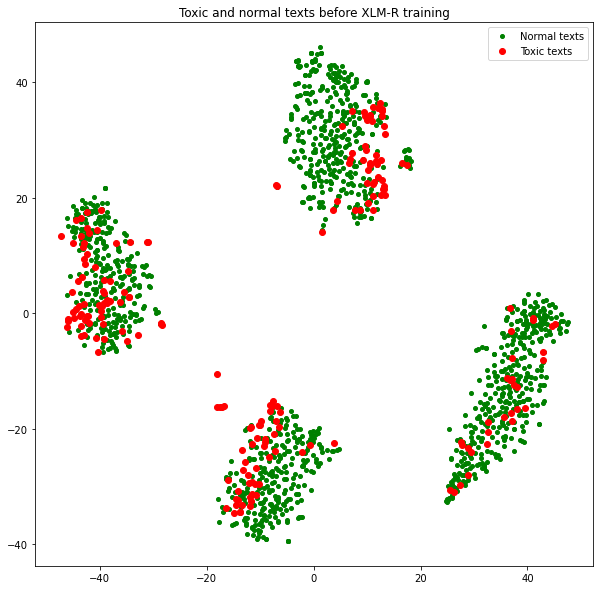

In [35]:
calculate_projections(data_for_cls_training, 'before XLM-R training')

Epoch 1/5
620/620 [==============================] - ETA: 0s - loss: 0.7905
Epoch 00001: val_loss improved from inf to 0.60619, saving model to /kaggle/working/siamese_xlmr.h5
620/620 [==============================] - 592s 956ms/step - loss: 0.7905 - val_loss: 0.6062
Epoch 2/5
620/620 [==============================] - ETA: 0s - loss: 0.5763
Epoch 00002: val_loss improved from 0.60619 to 0.60492, saving model to /kaggle/working/siamese_xlmr.h5
620/620 [==============================] - 587s 946ms/step - loss: 0.5763 - val_loss: 0.6049
Epoch 3/5
620/620 [==============================] - ETA: 0s - loss: 0.5591
Epoch 00003: val_loss improved from 0.60492 to 0.56872, saving model to /kaggle/working/siamese_xlmr.h5
620/620 [==============================] - 586s 946ms/step - loss: 0.5591 - val_loss: 0.5687
Epoch 4/5
620/620 [==============================] - ETA: 0s - loss: 0.5220
Epoch 00004: val_loss improved from 0.56872 to 0.50875, saving model to /kaggle/working/siamese_xlmr.h5
620/6

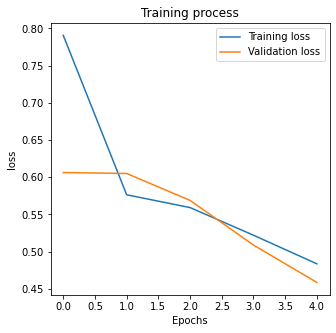

In [36]:
nn = train_siamese_nn(nn=siamese_network, trainset=dataset_for_training,
                 steps_per_trainset=n_batches_per_data,
                 steps_per_epoch=steps_per_single_epoch,
                 validset=dataset_for_validation,
                 model_weights_path=model_name)

In [37]:
siamese_network.load_weights(model_name)
feature_extractor.save_weights(fe_name)

In [38]:
dataset_for_training_ = calculate_features_of_texts(
    texts=multilingual_corpus,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    fe=feature_extractor,
    batch_size=batch_size_for_siamese
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Language "en": featurizing is finished.
Language "es": featurizing is finished.
Language "it": featurizing is finished.
Language "tr": featurizing is finished.


In [40]:
dataset_for_testing, n_batches_per_data = build_siamese_dataset(
    texts=corpus_for_testing, dataset_size=50000,
    tokenizer=xlmroberta_tokenizer, maxlen=max_seq_len,
    batch_size=batch_size_for_siamese, shuffle=True
)

In [41]:
data_for_cls_training, _ = generate_featured_data(
    dataset_for_training_,
)

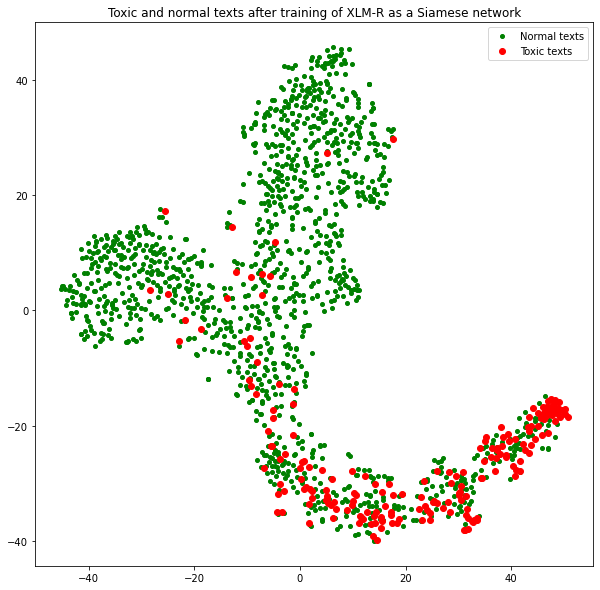

In [42]:
calculate_projections(data_for_cls_training, 'after training of XLM-R as a Siamese network')

In [43]:
def make_predictions(model):
    loaded_model = model 

    testset = dataset_for_testing

    testset_x, testset_y = next(iter(testset))

    predictions = loaded_model.predict(testset_x)

    binary_predictions = (predictions > 0.5).astype(np.int32)

    testset_y_flat = testset_y.numpy().flatten()

    accuracy = accuracy_score(testset_y_flat, binary_predictions)
    precision = precision_score(testset_y_flat, binary_predictions)
    recall = recall_score(testset_y_flat, binary_predictions)
    f1 = f1_score(testset_y_flat, binary_predictions)
    
    return accuracy, precision, recall, f1

In [79]:
acc, prec, rec, f1, auc = make_predictions(nn)
print('Test Dataset Metrics')
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)

Test Dataset Metrics
Accuracy: 0.65
Precision: 0.7478260869565218
Recall: 0.7258823529411764
F1-score: 0.71
